### Data

In [1]:
df = pd.read_pickle('data/df.pkl')
print(df.shape)
df[:2]

(84754, 21)


,AuthorID,Author,Date,Content,Attachments,Reactions,Date_day,Date_month,Date_quarter,id1,Channel1,Channel2,Channel2_img,flg_bot,Content2,cnt_messages,cnt_reactions,cnt_attachments,cnt_words,cnt_chars,flg_join
30165,451343325018980353,sheridan_oceanprotocol,2019-08-20 19:55:00,Joined the server.,NaN,NaN,2019-08-20,2019-08,2019Q3,30165,GENERAL,general-chat,💭,0,joined the server,0,0,0,3,18,1
30166,236850565382930432,kremalicious,2019-08-20 22:22:00,Joined the server.,NaN,NaN,2019-08-20,2019-08,2019Q3,30166,GENERAL,general-chat,💭,0,joined the server,0,0,0,3,18,1


In [2]:
# text preprocessing
df['Content'] = df['Content'].fillna('').map(lambda x: re.sub('http.*', 'http', x))
df['Content'] = df['Content'].fillna('').map(lambda x: re.sub('@[A-Za-z0-9_]+','user', x))

# filtering
f0 = df['cnt_words'] > 1
f1 = df['flg_join'] == 0
f2 = df['flg_bot'] == 0
f3 = df['Content'].str.contains('\?')
filt = f0&f1&f2&f3

df1 = df[filt].sort_values(['Channel2','Date'])
print(df1.shape)

(6290, 21)


175974


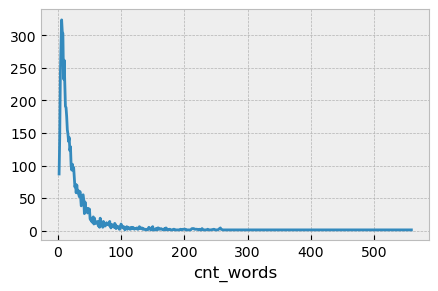

In [3]:
print(df1.cnt_words.sum())
_ = df1['cnt_words'].value_counts().sort_index().plot(figsize = (5,3))

In [4]:
text = list(df1['Content'])
len(text)

6290

### Get GPT-3.5 openai embeddings

In [5]:
import os

import hdbscan
import requests

import numpy as np
import pandas as pd
import plotly.express as px

from langchain import LLMChain
from langchain.chat_models import ChatOpenAI
# from langchain.embeddings.openai import OpenAIEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from sklearn.manifold import TSNE
from dotenv import load_dotenv

load_dotenv()

False

In [7]:
OPENAI_SECRET_KEY = os.getenv('OPENAI_SECRET_KEY')
model_emb = OpenAIEmbeddings(api_key = OPENAI_SECRET_KEY, chunk_size=1000)

In [8]:
list_emb = model_emb.embed_documents(text)

### Create clusters

In [10]:
model_cl = hdbscan.HDBSCAN(gen_min_span_tree=False, metric='euclidean', min_samples=1, min_cluster_size=2)
model_cl.fit(list_emb)

HDBSCAN(min_cluster_size=2, min_samples=1)

In [11]:
df1["cluster"] =  model_cl.labels_

### View results

In [33]:
df1['question_len'] = df1.groupby(['Channel2','cluster'])['AuthorID'].transform(len)
feats = ['Date','Author','Channel2','Content','cluster','question_len']
df1[feats][:10]

,Date,Author,Channel2,Content,cluster,question_len
15795,2023-03-24 03:30:00,doteth,ai-fun,user I want to build a data-driven dapp using data monetisation features from Ocean Protocol. What’s the best use case for a token-gated dapp?,924,1
15797,2023-03-24 03:31:00,doteth,ai-fun,user can you design a basic landing page for a data marketplace?,-1,37
15815,2023-03-28 06:06:00,nickscavuzzo33,ai-fun,user what was the popualtion of the world 1999?,-1,37
15819,2023-03-28 06:07:00,nickscavuzzo33,ai-fun,user what does GPT stand for?,-1,37
15817,2023-03-28 06:07:00,nickscavuzzo33,ai-fun,user what is a blockchain?,-1,37
15821,2023-03-28 12:17:00,robinlehmann,ai-fun,user new prompt: what does the Ocean Protocol core team do to have some fun?,-1,37
15824,2023-03-28 15:20:00,robinlehmann,ai-fun,user can you recommend a sea food?,-1,37
15828,2023-03-28 20:57:00,nickscavuzzo33,ai-fun,user how can i earn money with ocean protocol?,-1,37
15830,2023-03-28 20:58:00,nickscavuzzo33,ai-fun,user does ocean have a python library?,-1,37
15834,2023-03-28 20:59:00,robinlehmann,ai-fun,user what is the best dataset ever published on Ocean Protocol and why is it the best dataset?,-1,37


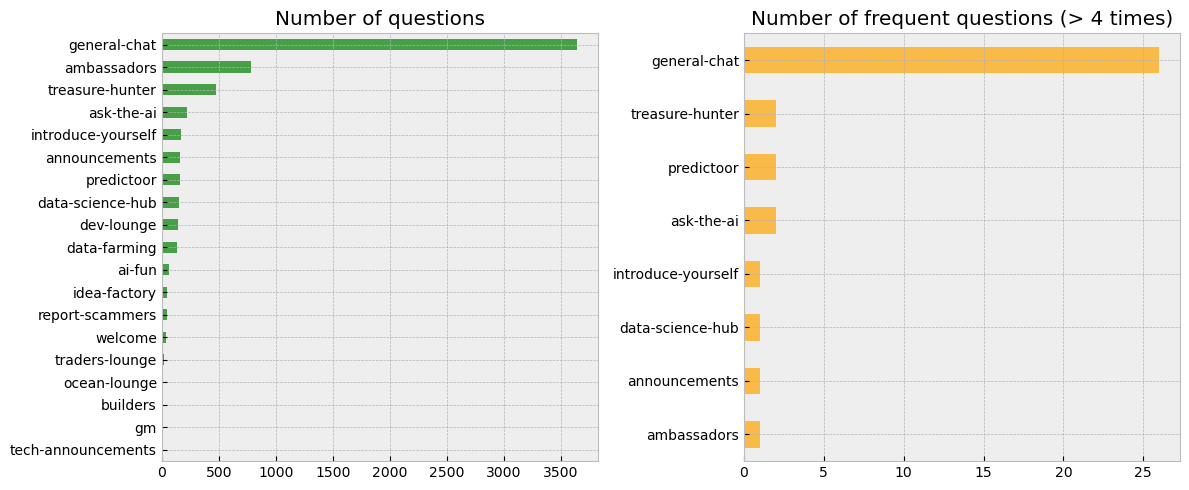

In [71]:
# TOP rankings
_, ax = plt.subplots(1,2, figsize = (12,5))

x = df1['Channel2'].value_counts()
_ = x.sort_values(ascending = True).plot(ax = ax[0], kind = 'barh', alpha = 0.7, color = 'Green', title = 'Number of questions', ylabel = '')

f1 = df1['cluster'] != -1
f2 = df1['question_len'] > 4
x = df1[f1&f2].groupby(['Channel2'])['cluster'].nunique()
_ = x.sort_values(ascending = True).plot(ax = ax[1], kind = 'barh', alpha = 0.7, color = 'Orange', title = 'Number of frequent questions (> 4 times)', ylabel = '')

plt.tight_layout()

In [74]:
# ['general-chat', 'ambassadors', 'treasure-hunter', 'ask-the-ai', 'predictoor', 'data-science-hub'][0]
f0 = df1['Channel2'] == 'general-chat'
f1 = df1['cluster'] != -1
f2 = df1['question_len'] > 4
x = df1[f0&f1&f2].groupby(['cluster']).Content.agg(lambda x: '\n'.join(x))

In [72]:
# pd.set_option('display.max_colwidth',1500)
# for k,v in dict(x).items():
#     print('---------')
#     print(k)
#     print(v)

In [75]:
pd.set_option('display.max_colwidth',1500)
for k,v in dict(x[:3]).items():
    print('---------')
    print(k)
    print(v)

---------
139
assume a pool  with 10 ocean and 10 DT.     1 DT = 1 OCEAN, right ?
so people need to add more dt to my pool for the price to drop ?
but if dt drops to 1 ocean ?
> you can see here it says no price found http
user - can you add a couple of DT back to the pool ?  the reserve is very low
should we mint more DT?
---------
353
Would you like to help me to get job opportunity on this platform?
do you have a chance to take some time off for me?
did you find time already?
is there any opportunity to work with you?
is there any opportunity to work with you?
---------
359
is that update out already?
Any idea when v4 will launch?
**1. When will v4 launch? What are the main features/updates of v4?**
When is v4 live?
Is v4 out yet?


In [ ]:
# Price-related and token manipulations:
# 	How do I connect my Metamask account to Ocean? Any tips or tutorials?
# 	Any bridge to move ocean from bsc to matic?
# 	Is $OCEAN available on Polygon network? if it is so, where can I buy it?
# 	Hello guys, can anyone send me a link how to bridge ocean for mocean in metamask?
# 	Where to buy Ocean?

# Technical:
# 	Have you seen the OpenAI API? I think it will be super interesting to see how we can integrate that with Ocean
# 	Any idea when v4 will launch?
# 	How do individuals get access to their data they want to sell on this platform?
# 	Data farming questions:
# 		Can you add a couple of DT back to the pool?
# 		Does anyone know why I did not get rewards for the first week? I had veOCEAN locked
# 		Rewards are still 0 correct? I can see my veOcean, so if I just hold them I'm eligeble for rewards no? But I have to allocate them to the pools to increase the rewards correct?
# 		Hello, if I allocate my veOCEAN tokens to earn active rewards, will this lower the passive rewards I have ?
# 		Anyone have any advice on staking in data sets?? How are the rewards dispensed. When i unstake to i get all Ocean tokens?
# 		I have a question about the active staking. With previous staking i believe you could lose out on your OCEAN tokens. Is it possible to lose some of your veOCEAN if you allocate it to a poor data set?
# 	Ambassadors:
# 		Hey, everybody. Where can I read more about the Ambassador Program?
# 		How can i become Ambassador?

# General information:
# 	What data is the most profitable? or good to invest now?
# 	Would you like to help me to get job opportunity on this platform?
# 	Hey guys, who can I talk to about a potential partnership idea?
# 	This is a scam right? http
# 	Are you still experiencing any issues ?
# 	Hi any admin here?
# 	Anybody active?🏋🏾‍♀️
# 	How is Ocean doing? Hello everyone! Have a fantastic day all 🙂

